***Imports***

In [1]:
import os
import glob
import json

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings

# Disable all warnings
warnings.filterwarnings('ignore')

# **Loading Data**

***Combining Json Files into DataFrame***

In [2]:
import glob

json_directory = '../data/raw_json_files'

json_file_paths = glob.glob(os.path.join(json_directory, '*.json'))
data = pd.DataFrame()

for path in json_file_paths: # loop to add information from each file into dataframe
    with open(path, 'r') as file:
        jsonfile = json.load(file)
    newdata = pd.json_normalize(jsonfile['data']['results'])
    data = pd.concat([newdata, data])

# **Data Cleaning**

***Selecting Columns for New Dataframe***

In [3]:
selected_columns = ['description.year_built', 'description.sqft', 'description.baths', 'description.stories',
                    'description.beds', 'description.garage', 'description.type', 'flags.is_foreclosure',
                    'location.address.city', 'tags', 'description.sold_price']

new_column_names = ['year_built', 'sqft', 'baths', 'stories', 'beds', 'garage', 'type', 'is_foreclosure',
                    'city', 'tags', 'price']

dataframe = data[selected_columns]
dataframe.columns = new_column_names

In [4]:
dataframe.to_csv('../data/raw_merged_df_data.csv') # Raw Data CSV

dataframe.head()

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,tags,price
0,1993.0,1926.0,2.0,1.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, community_golf, community_spa_or...",269000
1,2004.0,2298.0,3.0,2.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, dining_room, fireplace, forced_a...",315000
2,2003.0,2376.0,2.0,2.0,3.0,2.0,single_family,None,Indianapolis,"[central_air, community_security_features, din...",385000
3,1986.0,936.0,2.0,2.0,2.0,1.0,condos,None,Indianapolis,"[central_air, community_spa_or_hot_tub, dining...",161500
4,2003.0,3240.0,3.0,2.0,4.0,2.0,single_family,None,Indianapolis,"[city_view, community_park, community_spa_or_h...",310000


***Removing Nulls***

In [5]:
# Showing Nulls to remove
dataframe.isnull().sum()

year_built         875
sqft               868
baths              211
stories           1931
beds               687
garage            3743
type                66
is_foreclosure    8149
city                37
tags               553
price             1475
dtype: int64

In [6]:
# Removing Nulls that cannot be changed

dataframe = dataframe[(dataframe['price'] > 0) &
                      (dataframe['sqft'] > 0) &
                      (dataframe['year_built'] > 0) &
                      (dataframe['baths'] > 0) &
                      (dataframe['stories'] > 0) &
                      (dataframe['beds'] > 0) &
                      (dataframe['price'] > 0)]

In [7]:
# Changing Nulls to different values

dataframe['garage'].fillna(0, inplace=True) # if empty, no garages
dataframe['is_foreclosure'].fillna('False', inplace=True) # if not true, False

In [8]:
# Dropping Last missing Nulls

dataframe.dropna(inplace=True)

***Binding Selected Columns***

In [9]:
# Changing year_built into decades

bins = list(range(1820, 2031, 10))
labels = [i for i in bins[:-1]]

dataframe['year_built'] = pd.cut(dataframe['year_built'], bins=bins, labels=labels)
dataframe['year_built'] = dataframe['year_built'].astype(int)


In [10]:
# changing price into ranges

bins = list(range(0, 13000000, 200000))
labels = [i for i in bins[:-1]]

dataframe['price'] = pd.cut(dataframe['price'], bins=bins, labels=labels)
dataframe['price'] = dataframe['price'].astype(int)


In [11]:
# changing sqft into ranges

bins = list(range(0, 13000, 500))
labels = [i for i in bins[:-1]]

dataframe['sqft'] = pd.cut(dataframe['sqft'], bins=bins, labels=labels)
dataframe['sqft'] = dataframe['sqft'].astype(int)


***Separating Tag Column into Multiple Columns***

In [12]:
# Creating house_id to make sure the separation and merge is done correctly

dataframe['house_id'] = range(1, len(dataframe) + 1)


# Extract tags into a separate DataFrame

tags_expanded = dataframe[['house_id', 'tags']].explode('tags')
tags_expanded.rename(columns={'tags': 'tag'}, inplace=True)


#Filtering only top 20 most frequent tags

top_tags_name = tags_expanded['tag'].value_counts().head(20).index.to_list()

def remove_non_top_tags(row, top_tags_name): # removes any tags that are not in the top 20
    for i in top_tags_name:
        if i == row['tag']:
            return row

tags = tags_expanded.apply(remove_non_top_tags, args=(top_tags_name,), axis=1).dropna()

houseinfo_df = pd.merge(dataframe.drop(columns=['tags']), tags, on='house_id')

In [13]:
# One-hot encode the 'tag' column

one_hot_encoded_tags = pd.get_dummies(houseinfo_df['tag'])
one_hot_encoded_df = pd.concat([houseinfo_df[['house_id']], one_hot_encoded_tags], axis=1)


# Group by house_id and sum the one-hot encoded columns

one_hot_encoded_df = one_hot_encoded_df.groupby('house_id').sum().reset_index()


# Merging Dataframes Together

df_no_tags = houseinfo_df.drop(columns=['tag']).drop_duplicates(subset='house_id')
df_final = pd.merge(df_no_tags, one_hot_encoded_df, on='house_id')
#df_final.drop(columns='house_id', inplace=True) # remove house_id

# **Explore and Check Cleaned Data**

In [14]:
df_final.dtypes

year_built                       int64
sqft                             int64
baths                          float64
stories                        float64
beds                           float64
garage                         float64
type                            object
is_foreclosure                  object
city                            object
price                            int64
house_id                         int64
basement                         uint8
central_air                      uint8
central_heat                     uint8
city_view                        uint8
community_outdoor_space          uint8
community_security_features      uint8
dining_room                      uint8
dishwasher                       uint8
fireplace                        uint8
forced_air                       uint8
garage_1_or_more                 uint8
garage_2_or_more                 uint8
hardwood_floors                  uint8
laundry_room                     uint8
recreation_facilities    

##### ***Observation Summary/Findings***

Except for `is_foreclosure`, `city`, and `type` all the features are in the integer datatype. Although more of than half of the columns are in integers due to one hot encoding and was originally categorical data. The remaining categorical data will later be one hot encoded with the rest of the data.

In [15]:
df_final.isnull().sum()

year_built                     0
sqft                           0
baths                          0
stories                        0
beds                           0
garage                         0
type                           0
is_foreclosure                 0
city                           0
price                          0
house_id                       0
basement                       0
central_air                    0
central_heat                   0
city_view                      0
community_outdoor_space        0
community_security_features    0
dining_room                    0
dishwasher                     0
fireplace                      0
forced_air                     0
garage_1_or_more               0
garage_2_or_more               0
hardwood_floors                0
laundry_room                   0
recreation_facilities          0
shopping                       0
single_story                   0
two_or_more_stories            0
view                           0
washer_dry

##### ***Observation Summary/Findings***

All the nulls were successfully removed and should not cause any issues in the modelling process.

In [16]:
df_final.describe()

,year_built,sqft,baths,stories,beds,garage,price,house_id,basement,central_air,...,garage_1_or_more,garage_2_or_more,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer
count,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4.838000e+03,4838.000000,4838.000000,4838.000000,...,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000
mean,1964.774700,1638.176933,2.326995,1.604795,3.170112,1.154609,3.380736e+05,2419.500000,0.446259,0.619057,...,0.656470,0.446052,0.365647,0.282141,0.264986,0.287929,0.505374,0.494626,0.223646,0.314593
std,34.806843,1005.451208,1.021649,0.764951,1.078383,1.117118,5.766325e+05,1396.754631,0.497155,0.485669,...,0.474936,0.497132,0.481661,0.450088,0.441371,0.452845,0.500023,0.500023,0.416731,0.464401
min,1820.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1950.000000,1000.000000,2.000000,1.000000,3.000000,0.000000,2.000000e+05,1210.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,1500.000000,2.000000,1.000000,3.000000,1.000000,2.000000e+05,2419.500000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1990.000000,2000.000000,3.000000,2.000000,4.000000,2.000000,4.000000e+05,3628.750000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,2020.000000,11000.000000,9.000000,10.000000,12.000000,9.000000,1.240000e+07,4838.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### ***Observation Summary/Findings***

Judging from the minimum and maximum for each numerical feature, there is no unrealistic impossible data that needs to be removed. Although there seems to be multiple outliers due to the mean not completely reflecting the range of the data. Despite there being clear outliers we made the decision not to remove them, in order for our model to be able to understand that there is data that is possible.

In [17]:
df_final.shape

(4838, 31)

##### ***Observation Summary/Findings***

We were able to filter our data to almost 5000 houses, and contain 30 different features for each house. It is to be noted that 20 of the features are due to one hot encoding and there is still other columns that may need to be one hot encoded for the modeling process.

### ***Finished Cleaned Data***

In [18]:
df_final.head()

,year_built,sqft,baths,stories,beds,garage,type,is_foreclosure,city,price,...,garage_1_or_more,garage_2_or_more,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer
0,1990,1500,2.0,1.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,1,0,1,0,1,0
1,2000,2000,3.0,2.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,0,0,0,1,0,0
2,2000,2000,2.0,2.0,3.0,2.0,single_family,False,Indianapolis,200000,...,1,1,1,0,0,0,0,1,1,0
3,1980,500,2.0,2.0,2.0,1.0,condos,False,Indianapolis,0,...,1,0,0,0,1,1,0,1,1,0
4,2000,3000,3.0,2.0,4.0,2.0,single_family,False,Indianapolis,200000,...,1,1,0,0,1,1,0,1,1,0


# **Perform Train Test Split**

In [19]:
X = df_final.drop('price', axis=1)
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {y_train.shape}")
print(f"Y_test shape: {y_test.shape}")

X_train shape: (3870, 30)
X_test shape: (968, 30)
Y_train shape: (3870,)
Y_test shape: (968,)


In [20]:
#Exporting test/training data into CSV

X_train.to_csv('../data/training/X_train.csv', index=False)
X_test.to_csv('../data/testing/X_test.csv', index=False)
y_train.to_csv('../data/training/y_train.csv', index=False)
y_test.to_csv('../data/testing/y_test.csv', index=False)

In [21]:
# Export processed dataframe before visualization - df_final to CSV
df_final.to_csv('../data/processed/df_final_processed_no_bins.csv', index=False)

In [22]:
df_final['house_id']

0          1
1          2
2          3
3          4
4          5
        ... 
4833    4834
4834    4835
4835    4836
4836    4837
4837    4838
Name: house_id, Length: 4838, dtype: int64

# **Exploratory Data Analysis (EDA)**

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process, and visualizations play a fundamental role in understanding the dataset, uncovering patterns, and identifying relationships between variables. We (Kiran and I) chose 6 from an exhaustive list to show the correlation of the selected features and their respective impact to the price/cost of the house. The purpose and importance of each visualization is shown below along with a summary of the results.


#### 1. ***Correlation Heatmap***
**Purpose**: To identify the strength and direction of relationships between numerical features.
**Reason**: 
- Helps in understanding which features are strongly correlated with the target variable (`price`).
- Identifies multicollinearity among features, which can inform feature selection and engineering.
- Guides further analysis by highlighting key variables that significantly influence the target variable.

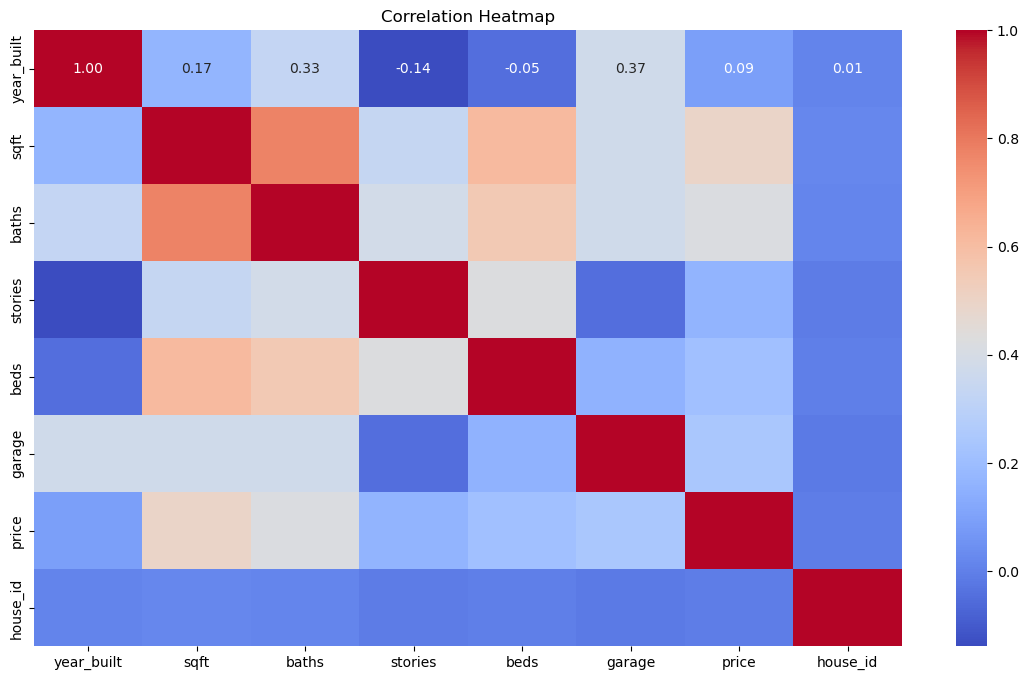

<Figure size 640x480 with 0 Axes>

In [29]:
# Select only numeric columns
numeric_df = df_final.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
plt.savefig('../images/correlation_heatmap.png', format='png')

##### ***Observation Summary/Findings***

The heatmap provides a visual summary of the correlation coefficients between different features and the price. Features like `sqft`, `baths`, `garage`, and `year_built` show moderate positive correlations with price, indicating they are important factors influencing house prices. Other features show weaker correlations, highlighting areas where further investigation or feature engineering might be needed to understand their impact on price. The heatmap helps in identifying both strong and weak relationships, guiding further analysis and model development.

#### 2. ***Pairplot***
**Purpose**: To visualize pairwise relationships and distributions of numerical features.\
**Reason**: 
- Provides a comprehensive view of the interactions between features.
- Helps in spotting trends, clusters, and outliers.
- Facilitates the detection of potential non-linear relationships that might require transformation or advanced modeling techniques.
- Offers insights into the overall distribution of each feature, aiding in understanding their spread and central tendencies.

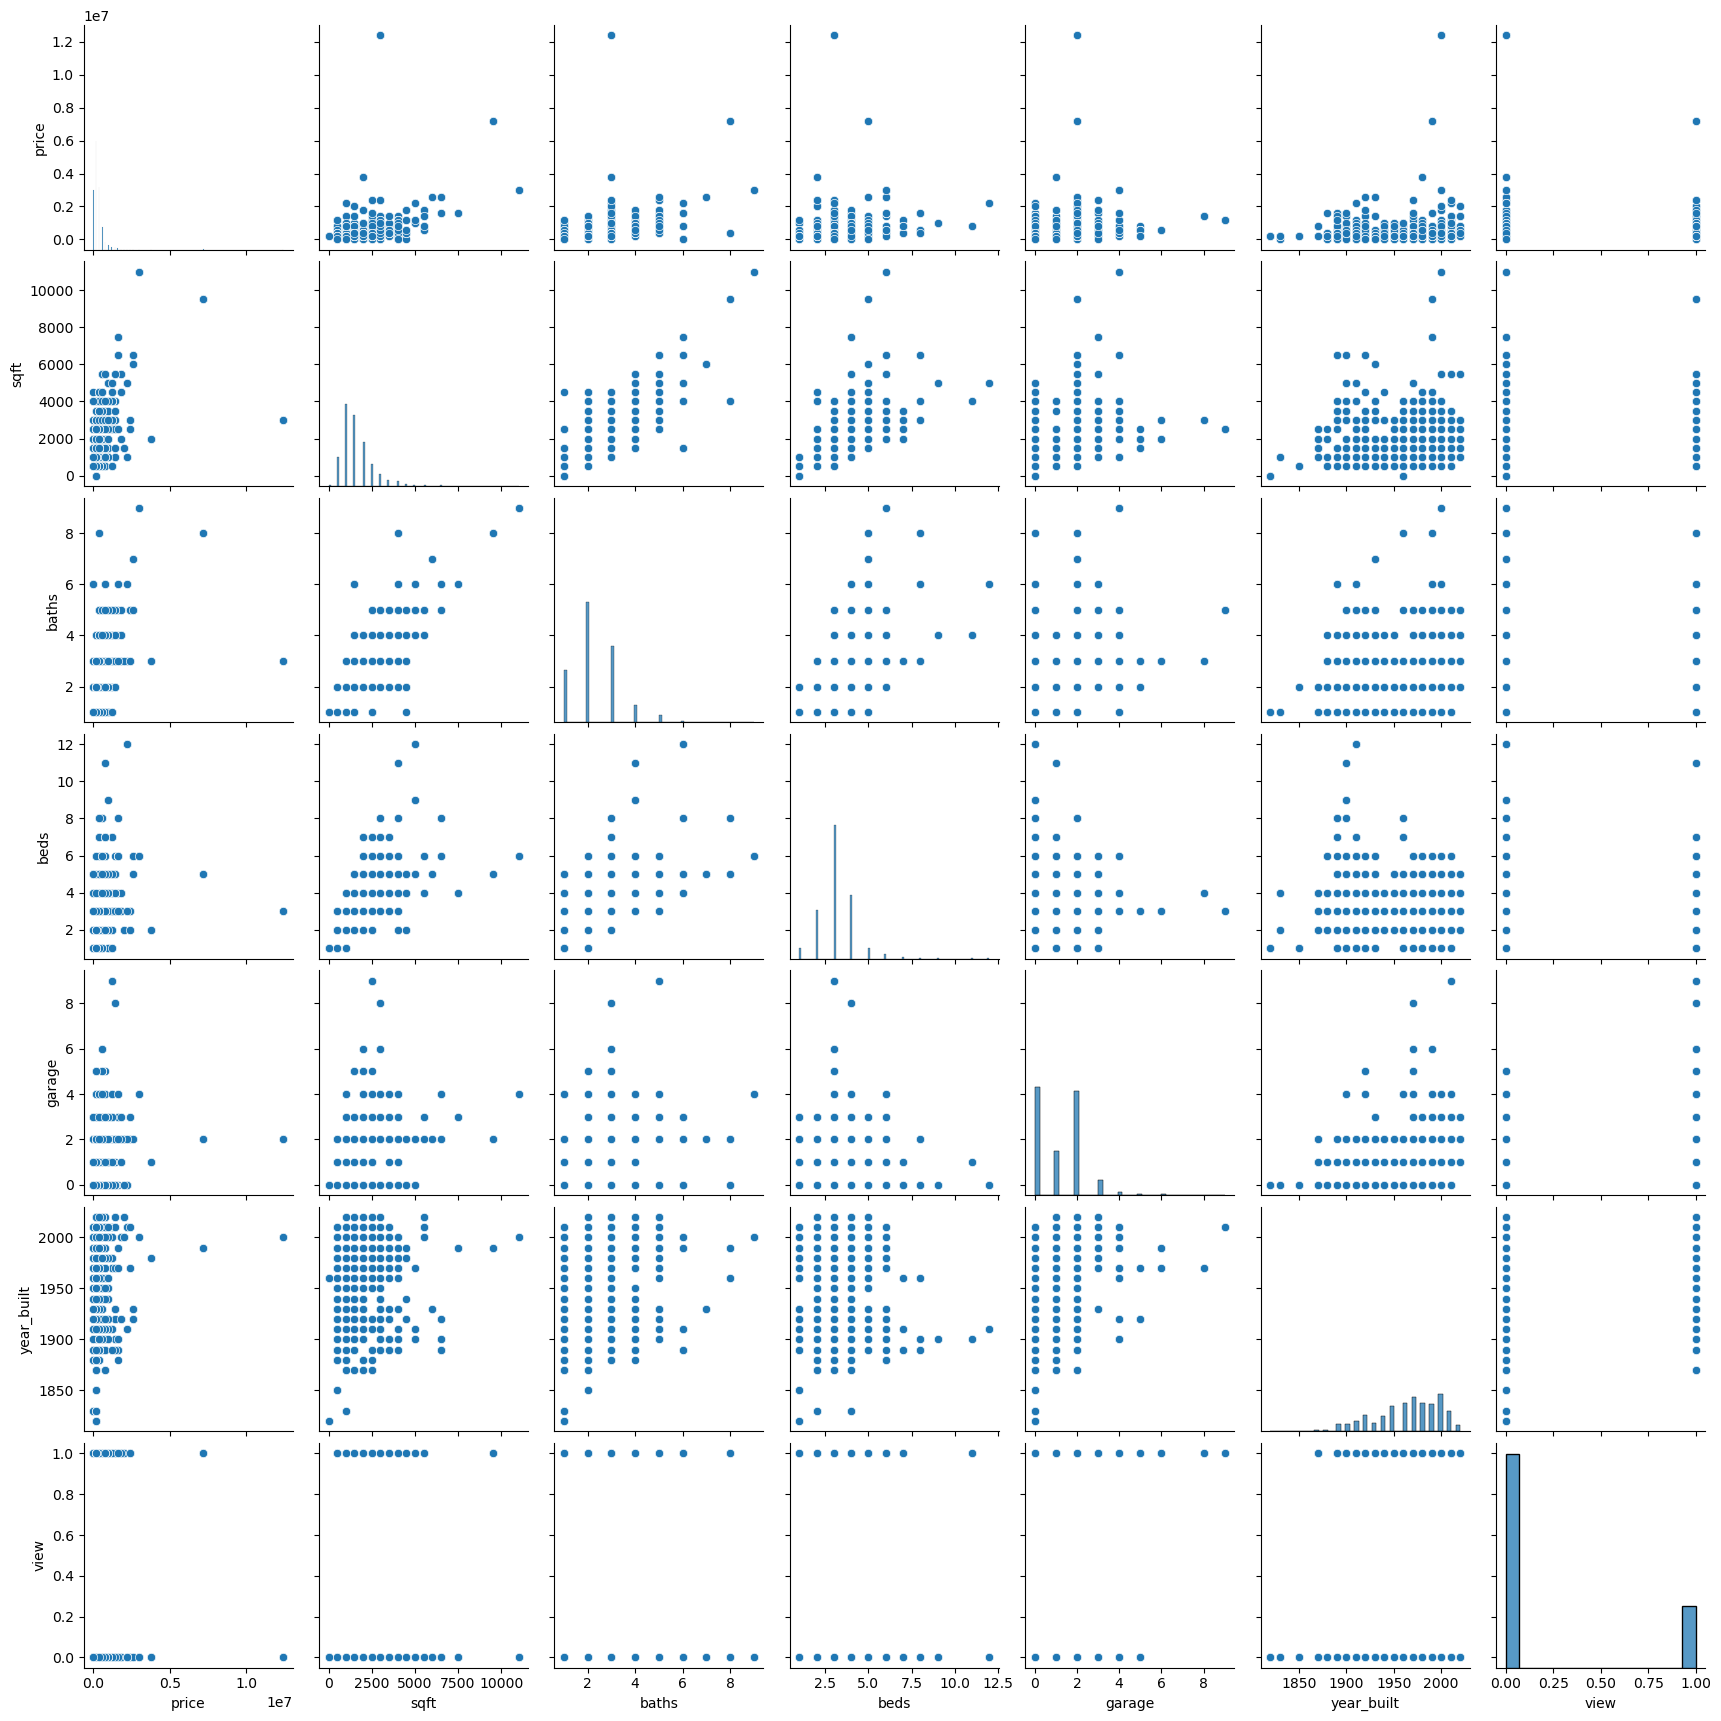

<Figure size 640x480 with 0 Axes>

In [24]:
# Pairplot for numerical features

selected_features = ['price', 'sqft', 'baths', 'beds', 'garage', 'year_built', 'view']
sns.pairplot(df_final[selected_features], palette="viridis")
plt.show()

plt.savefig("../images/pair_plot.jpg")

##### ***Observation Summary/Findings***
The pairplot reveals important relationships between the selected features and `price`. Key insights include the positive correlations of `price` with `sqft`, `baths`, `beds`, `garage`, and `year_built`, indicating that these features are important determinants of house prices. The distribution and scatterplots help in understanding the spread and variability within these relationships, identifying potential trends, and highlighting outliers. This comprehensive view aids in further analysis and informs feature selection for predictive modeling.

#### 3. ***Price Distribution Plot***
**Purpose**: To examine the distribution of the target variable (`price`).
**Reason**: 
- Reveals the central tendency, variability, and skewness of house prices.
- Identifies potential outliers and unusual data points that might require special handling.
- Provides a clear picture of the overall price range and helps in setting realistic expectations for predictive modeling.

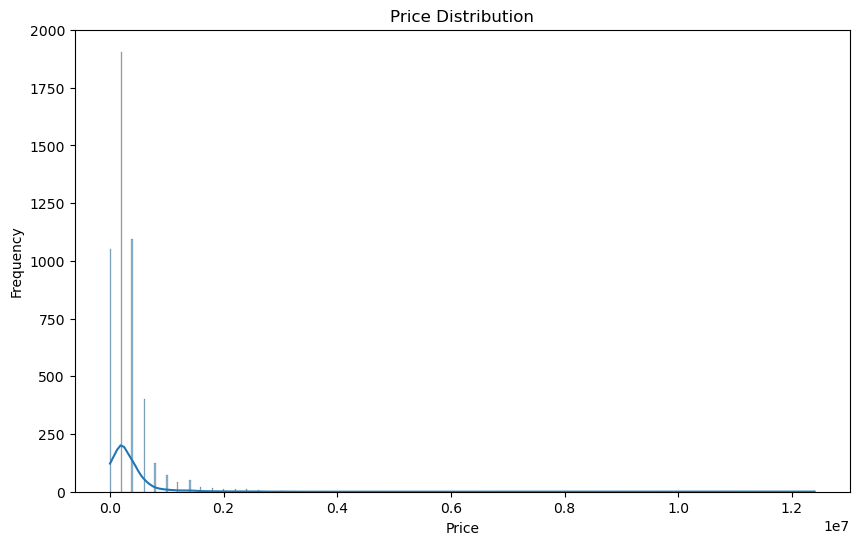

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['price'], kde=True, palette="viridis")
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.savefig("../images/price_distribution.jpg")

#### ***Observation Summary/Findings***

The price distribution plot shows the frequency distribution of house prices in the dataset. Here are the key observations from the plot:

1. **Right-Skewed Distribution**:
   - The distribution is highly right-skewed, with a long tail extending towards the higher price values.
   - Most of the houses are clustered at the lower end of the price range, indicating that lower-priced houses are much more common in the dataset.

2. **Peak Frequency**:
   - There is a sharp peak at the very low end of the price range, suggesting a high concentration of houses priced at the lower end.
   - The highest frequency is observed for houses priced close to the lower limit, indicating a large number of affordable houses.

3. **Outliers**:
   - The long tail extending to the right indicates the presence of outliers, which are houses with very high prices.
   - These outliers are significantly fewer in number compared to the lower-priced houses but have a substantial impact on the overall price distribution.

4. **Kernel Density Estimate (KDE)**:
   - The KDE line provides a smooth estimate of the distribution, further highlighting the right-skewness and the concentration of prices at the lower end.

5. **Price Range**:
   - The x-axis shows that house prices range from close to zero up to over 10 million (1e7).
   - The majority of the data points fall within the first quarter of the price range, with a sharp decline in frequency as prices increase.

### ***Summary***

The price distribution plot reveals that the dataset is dominated by lower-priced houses, with a significant right-skewness indicating the presence of a few very high-priced properties. This distribution suggests that while most houses are affordable, there are some luxury properties that significantly raise the upper limit of the price range. 

#### 4. ***Box Plots***
**Purpose**: To check for outliers and understand distribution of data.
**Reason**: 
- Can reveal possible outliers needed for removing
- Allow comparisons to other features
- Show distribution in the data


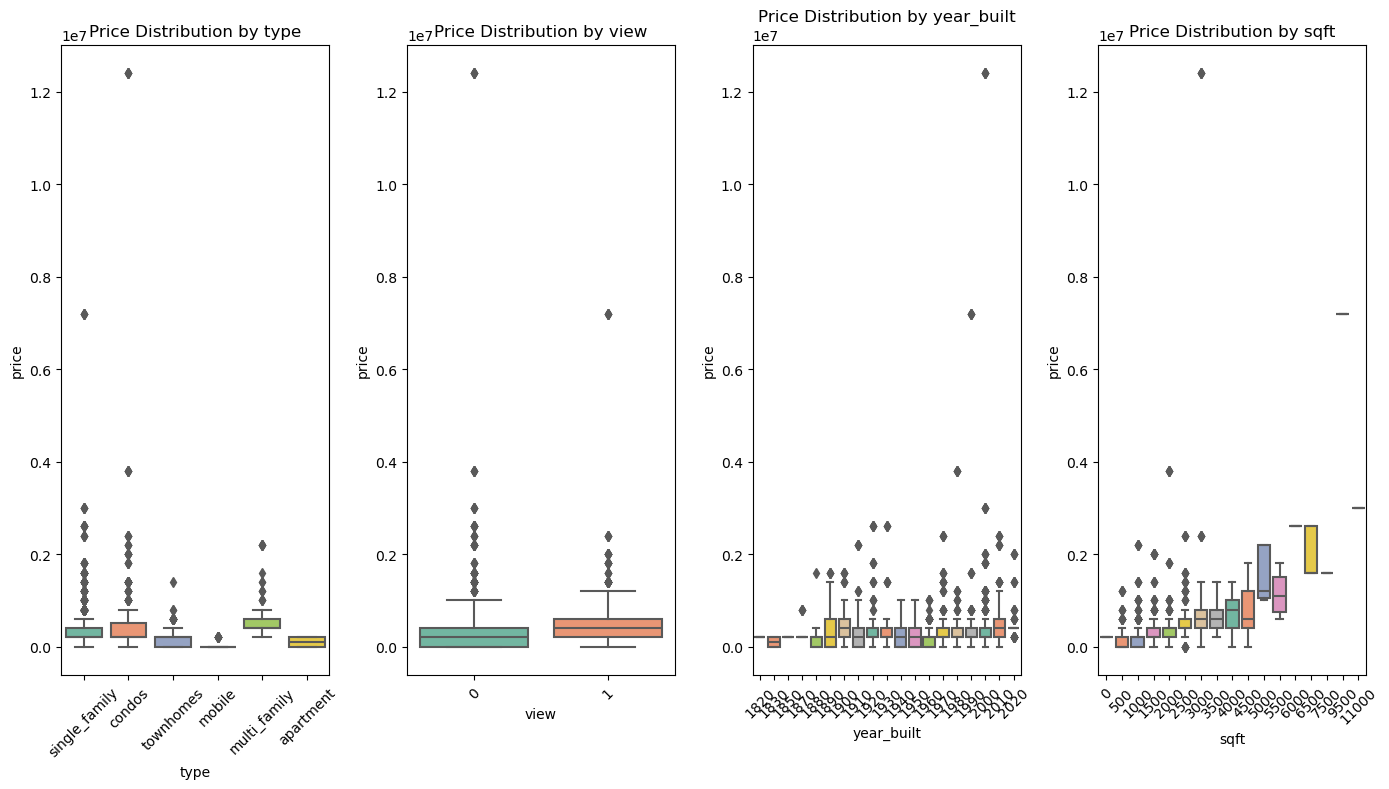

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot boxplots for features

test_features = ['type', 'view', 'year_built', 'sqft']

plt.figure(figsize=(14, 8))
for i, feature in enumerate(test_features, 1): # plotting each category
    plt.subplot(1, len(test_features), i)
    sns.boxplot(x=df_final[feature], y=df_final['price'], palette="Set2")
    plt.title(f'Price Distribution by {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.savefig("../images/box_plots.jpg")

#### ***Observation Summary/Findings***
The box plot is helpful in checking for outliers and showing the distribution of multiple features. Certain features like `mobile`, show very little variance in data. While other features such as `1890` have higher variance. There are also numerous outliers with some extreme ones being in the `condos` and `view` category.

#### 5. ***Bar Graphs for Categorical Features***
**Purpose**: To compare the average price across different categories of categorical features.
**Reason**: 
- Highlights how categorical variables like `type` and `isforeclosure` influence house prices.
- Assists in identifying significant categorical variables that impact the target variable.
- Helps in understanding the distribution of prices across different groups, which is essential for segment analysis and targeted strategies.

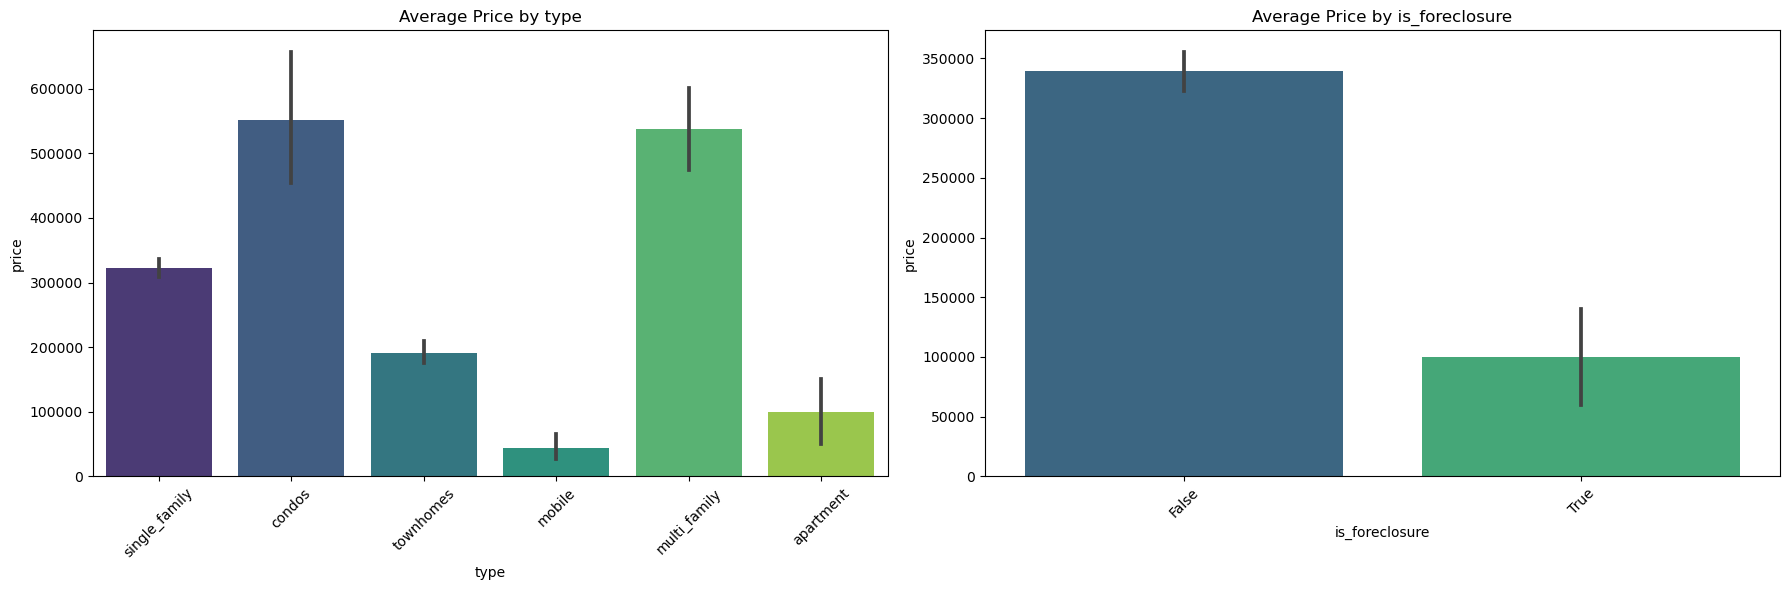

<Figure size 640x480 with 0 Axes>

In [27]:
categorical_features = ['type', 'is_foreclosure']

plt.figure(figsize=(18, 6))
for i, feature in enumerate(categorical_features, 1): # plotting each category
    plt.subplot(1, len(categorical_features), i)
    sns.barplot(x=feature, y='price', data=df_final, palette="viridis")
    plt.title(f'Average Price by {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.savefig("../images/bar_graphs_categorical.jpg")

#### ***Observation Summary/Findings***
The bar graphs provide valuable insights into how categorical features like property type, year built, and foreclosure status impact house prices:

- **Property Type**: Single-family homes are generally the most expensive, followed by townhomes and condos.
- **Foreclosure Status**: Foreclosed properties are sold at lower prices compared to non-foreclosed homes.


#### 6. ***Bar Graphs for Numerical Features***
**Purpose**: To show the average price across different bins of numerical features.
**Reason**: 
- Demonstrates how changes in numerical features like `sqft`, `baths`, `beds`, `garage`, and `year_built` affect house prices.
- Facilitates the understanding of non-linear relationships by visualizing average prices across feature bins.
- Helps in identifying thresholds and breaking points where the impact of numerical features on price changes significantly.

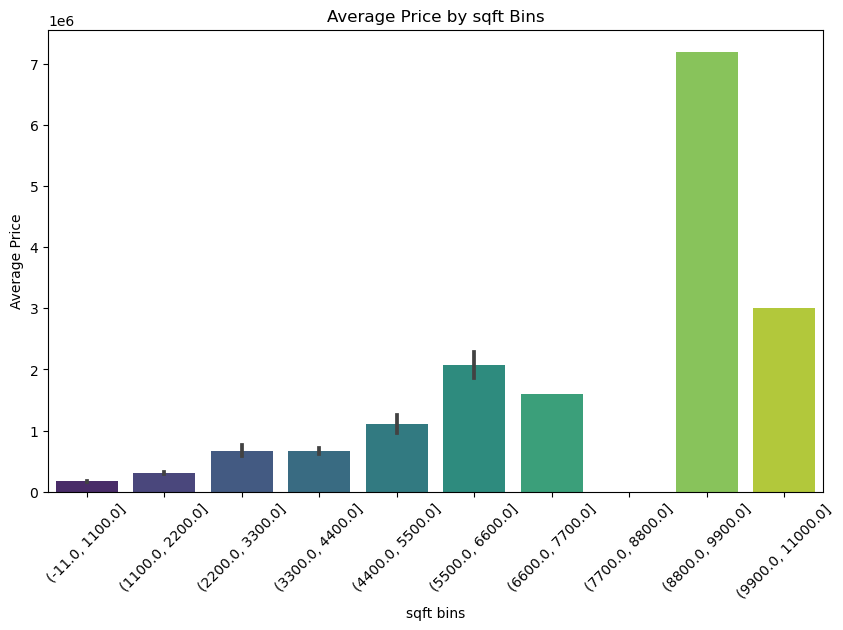

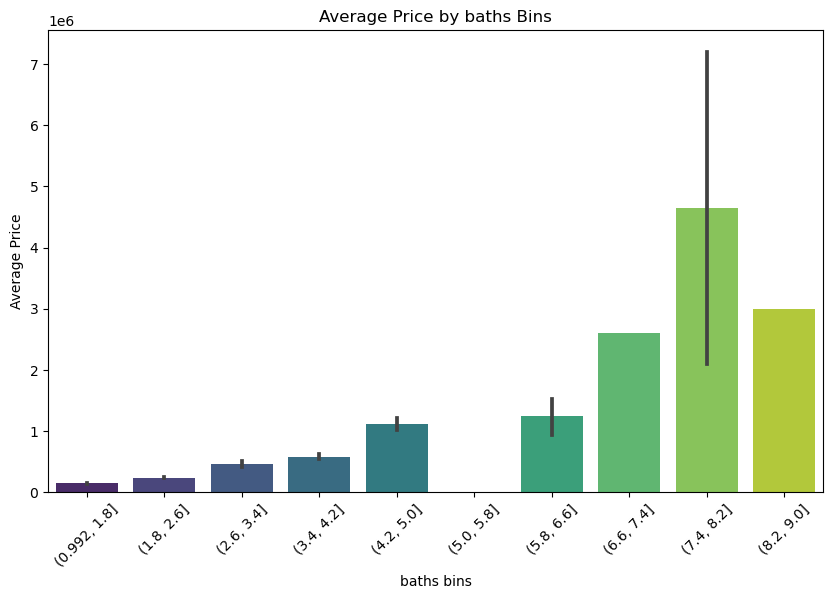

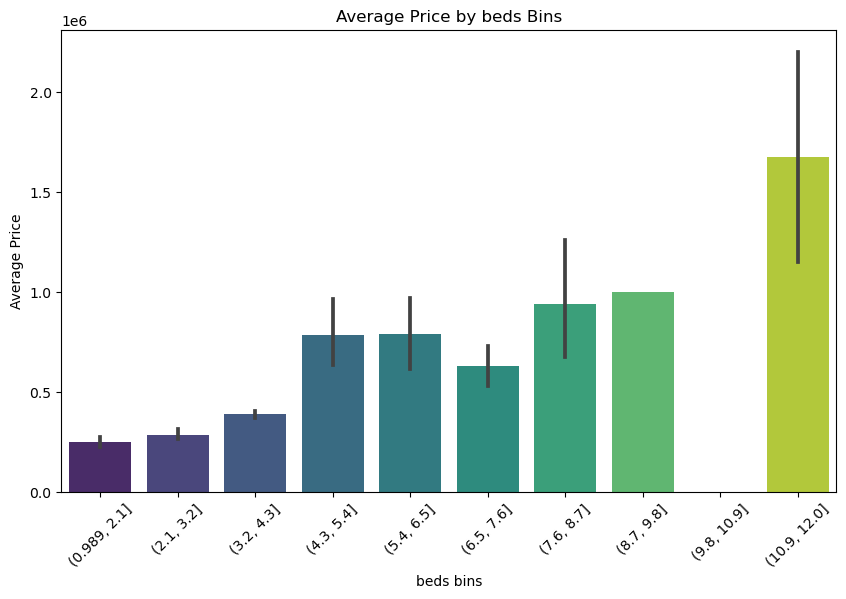

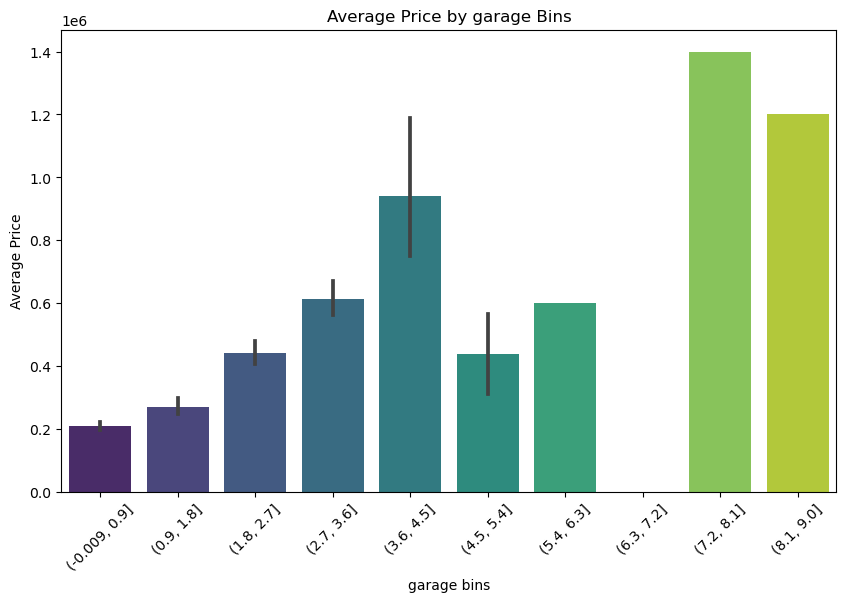

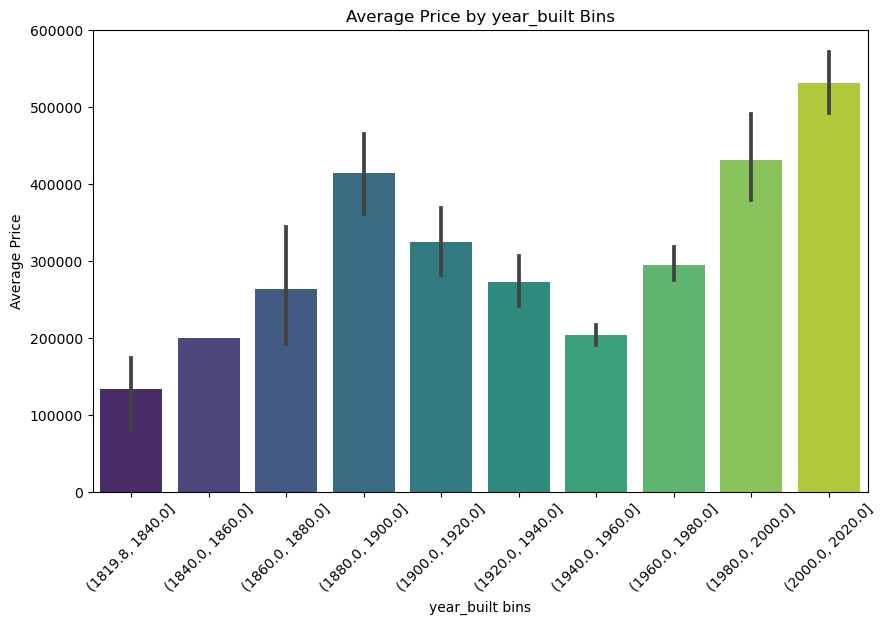

<Figure size 640x480 with 0 Axes>

In [28]:
numerical_features = ['sqft', 'baths', 'beds', 'garage', 'year_built']

def plot_numerical_feature_binned(df, feature, bins=10): # create bins and plot graphs
    df_final[f'{feature}_bin'] = pd.cut(df_final[feature], bins=bins)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=f'{feature}_bin', y='price',
                data=df_final, palette="viridis")
    plt.title(f'Average Price by {feature} Bins')
    plt.xticks(rotation=45)
    plt.xlabel(f'{feature} bins')
    plt.ylabel('Average Price')
    plt.show()

for feature in numerical_features: # loop through each feature
    plot_numerical_feature_binned(df_final, feature, bins=10)

plt.savefig("../images/bar_graphs_numerical.jpg")

#### ***Observation Summary/Findings***
The bar graphs provide valuable insights into how numerical features like year built, garage, baths and bins impact house prices:

- **Sqft**: Bigger the sqft the higher the price of the house
- **Baths**: Foreclosed properties are sold at lower prices compared to non-foreclosed homes.
- **Beds**: More bedrooms have a higher price and steadily decreases with lower beds
- **Garage**: Garages seem to have 2 peaks with price increasing by number of garages until 4.5 where it drops to then climb to a higher price
- **Year Built**: Newer homes tend to have higher prices, with prices decreasing for older homes.